In [86]:
import numpy as np
from skimage import io
from skimage.filters import threshold_otsu, threshold_local
from skimage.color import rgb2gray
from scipy.ndimage.measurements import label
from skimage.segmentation import clear_border
from scipy.ndimage.morphology import binary_fill_holes
from scipy.ndimage.measurements import center_of_mass
from scipy.spatial.distance import euclidean
from skimage.transform import rotate
import re
import matplotlib.pyplot as plt
from itertools import zip_longest


In [87]:
'''
geometric functions for rotation

'''

def get_extreme(indexes):
    
    x_max = indexes[:,1].max()
    x_min = indexes[:,1].min()    
    
    y_max = indexes[:,0].min()   
    y_min = indexes[:,0].max()
    
    return x_min, x_max, y_min, y_max

def get_3_vertexes(indexes):
   
    x_min, x_max, y_min, _ = get_extreme(indexes)
    
    right_extreme = np.array([(indexes[indexes[:,1]==x_max])[:,0].max(), x_max])
    left_extreme = np.array([(indexes[indexes[:,1]==x_min])[:,0].max(), x_min])   
    bottom_extreme = np.array([y_min, (indexes[indexes[:,0]==y_min])[:,1].mean()]).astype(int)
    
    return bottom_extreme, left_extreme, right_extreme
    
def what_side(points, indexes, inplace=True):
    '''
    points[0] = bottom_extreme
    points[1] = left_extreme
    points[2] = right_extreme
    
    if inplace: change coords of bottom w.r.t nearest vertex
    
    return 0 if closer to left
           1 if closer to right
           -1 if in the middle 
    '''
    
    bottom_extreme = points[0]
    
    to_left = euclidean(bottom_extreme, points[1])
    to_right = euclidean(bottom_extreme, points[2])
    
    if np.isclose(to_left, to_right, atol=2.5):
        return -1
    
    res = int(to_left > to_right)
    
    if inplace:
        bottom_extreme_y = bottom_extreme[0]
        if res:           
            bottom_extreme_x = (indexes[indexes[:,0]==bottom_extreme_y])[:,1].max()      
        else:
            bottom_extreme_x = (indexes[indexes[:,0]==bottom_extreme_y])[:,1].min()               
        points[0][0] = bottom_extreme_y
        points[0][1] = bottom_extreme_x
    
    return res
            
def specify_vertexes(cropped_img):
    indexes = get_indexes_img(cropped_img)
    x_min, x_max, y_min, y_max = get_extreme(indexes)
    points = get_3_vertexes(indexes)
    points = np.array(points)
    res = what_side(points, indexes, inplace=True)
    
    return res, points 
    
def get_indexes_img(binary_img):
    mask = binary_img==1
    return(np.argwhere(mask))

def get_norm(vec):
    return np.sqrt((vec * vec).sum())

def get_angle_and_bottom_offset(cropped_img, bottom_vertex, closer_to_right):    
    
    if closer_to_right == -1:
        # do need need rotatr
        bottom_offset = cropped_img.shape[0] - bottom_vertex[0]
        angle_rotate = 0;
        return angle_rotate, bottom_offset
    
    yc, xc = center_of_mass(cropped_img)
    cen_mass = np.array([yc, xc])
    len_side = euclidean(cen_mass, bottom_vertex)
    if closer_to_right:
        new_vertex_x = xc - len_side/2
    else:
        new_vertex_x = xc + len_side/2
    new_vertex_y = len_side * np.sqrt(3)/2 + yc
    new_vertex = np.array([new_vertex_y, new_vertex_x])
    
    vec_to_old = bottom_vertex - cen_mass
    vec_to_new = new_vertex - cen_mass

    angle_rotate = np.arccos(
        np.dot(vec_to_new, vec_to_old) / (get_norm(vec_to_new) * (get_norm(vec_to_old))))
    angle_rotate = angle_rotate * 180 / np.pi
    
    bottom_offset = cropped_img.shape[0] - new_vertex_y    
    return angle_rotate, bottom_offset
    


In [88]:
'''
functions for transformation image and detection areas

'''
def binarize(img, plot=True):   
    binary_img = rgb2gray(img) 
    binary_img = binary_img < threshold_otsu(binary_img)
    binary_img = binary_fill_holes(binary_img)
    if plot:
        io.imshow(binary_img)
        plt.title('binarized')
        plt.show()
    return binary_img
    
def crop(img, already_binarized, plot=True):  
    '''
    return cropped coloured picture
           and cropped binarized picture
    '''
    
    if not already_binarized:
        binary_img = binarize(img, False)
    else:
        binary_img = img
    indexes = get_indexes_img(binary_img)
    x_min, x_max, y_min, y_max = get_extreme(indexes)
    img_bin_cropped = binary_img[y_max:y_min, x_min:x_max]
    img_cropped = img[y_max:y_min, x_min:x_max]
    
    if plot:
        io.imshow(img_cropped)
        plt.title("Not rotated chip")
        plt.show()
    return img_cropped, img_bin_cropped


def cut_fragment(img_rotated, bottom_offset):
    fragment = img_rotated[:-bottom_offset,:]
    horisontal_size = 0.25
    vertical_size = 1/6
    bottom_offset_relative = 1/10
    middle_x = int(img_rotated.shape[1]/2)


    bottom_edge = (int)(img_rotated.shape[0]*(1-bottom_offset_relative))
    top_edge = (int)(fragment.shape[0]*(1-vertical_size))

    left_edge = middle_x - int(fragment.shape[1]*horisontal_size)
    right_edge = middle_x + int(fragment.shape[1]*horisontal_size)
    
    return fragment[top_edge:bottom_edge,left_edge:right_edge]



In [89]:
'''
detection colour of edge

'''

BLACK = 2
RED = 1
YELLOW = 0
NOT_SORTED = -1


def detect_colour(pixel):
    #don't distinguish here dark blue and black
    res = np.zeros((3,))   
        
    if(np.allclose(pixel, [0.73, 0.55, 0.1], atol=0.14)):
        res[YELLOW] = 1
    if(np.allclose(pixel, [0.62, 0.18, 0.11], atol=0.14)):
        res[RED] = 1
    if res.sum() == 0:
        res[BLACK] = 1
    return np.argmax(res)

def colours_in_fragment(fragment, return_distinct_img):
    black = 0
    red = 0
    yellow = 0
    new_img = np.zeros_like(fragment)

    for i, row in enumerate(fragment):
        for j, pixel in enumerate(row):
            colour = detect_colour(pixel)
            if colour == BLACK:
                black += 1
                new_img[i, j] = np.array([0, 0, 0])
        
            elif colour == RED:
                red += 1
                new_img[i, j] = np.array([1, 0, 0])
        
            elif colour == YELLOW:
                yellow += 1
                new_img[i, j] = np.array([1, 1, 0])
        
            else:
                not_sorted += 1
                new_img[i, j] = np.array([1, 1, 1])
    
    if return_distinct_img:
        return yellow, red, black, new_img
    
    return yellow, red , black

In [90]:
'''
some additional functions

'''


def shift_str(str_code):
    return str_code[-1:] + str_code[:-1]

def type_lines(num_chip):
    print(num_chip)
    return LINES_DICT[num_chip+1]

def recognize_chip(str_code, return_lines=False):         
    for num_chip, pattern in enumerate(ALL_PATTERN_CHIPS):
        for i in range(0, 6):
            if re.match(pattern, str_code):
                if return_lines:
                    return type_lines(num_chip)
                else:
                    return num_chip + 1
            str_code = shift_str(str_code)
    return -1    
    
def read_img(type_input, name):
    if type_input == 'group':
        path = PATH_GROUP + name
    elif type_input == 'single':
        path = PATH_SINGLE + name
    else:
        raise TypeError
    
    img = io.imread(path) 
    if np.max(img) > 1:
          img = img / 256
    
    return img    
    

In [96]:
'''
main functions

'''


def get_one_chip(img, show=False):
    str_code = ""
    exact_coef_coloured = 1/10
    exact_coef_black = 1/30
    cropped_img, cropped_img_bin = crop(img, False, show)
    closer_to_right, vertexes = specify_vertexes(cropped_img_bin)
    angle_rotate, bottom_offset = get_angle_and_bottom_offset(
        cropped_img_bin, vertexes[0], closer_to_right)

    if closer_to_right:
        angle_rotate = -angle_rotate
    
    for i in range(0, 6):
        angle = angle_rotate + i*60
        img_rotated = rotate(cropped_img, angle)
        
        if show:
            io.imshow(img_rotated)
            plt.show()
        
        fragment = cut_fragment(img_rotated, bottom_offset)
        yellow, red, black, new_img = colours_in_fragment(fragment, True)           
        yellow_rel = yellow/black
        red_rel = red/black
        
        if show:
            print('yellow: {0}  red: {1}  black: {2}'.format(yellow, red, black))
            print('relative yellow: {0}, relative red: {1}'.format(yellow_rel, red_rel))
            fig, axes = plt.subplots(1,2)
            axes[0].imshow(fragment)
            axes[1].imshow(new_img)
            plt.show()
        
        if yellow_rel > exact_coef_coloured and red_rel > exact_coef_coloured:
            label = '.'  
        elif yellow_rel > exact_coef_coloured:
            label = str(YELLOW)
        elif red_rel > exact_coef_coloured:
            label = str(RED)
        elif yellow_rel < exact_coef_black and red_rel < exact_coef_black:
            label = str(BLACK)
        else:
            label = '.'
        if show:
            if label == str(BLACK):
                print('this side is recognized as blue')
            if label == str(RED):
                print('this side is recognized as red')
            if label == str(YELLOW):
                print('this side is recognized as yellow')
            print('\n\n')
        
        str_code = str_code + label
    return str_code
    
    
def get_all_chips(img_group, plot_every_chip=False):
    coef_max_yet_chip = 0.5  
    chips = list()
    list_centers = list()


    binary_img = binarize(img_group, plot_every_chip)
    labels = clear_border(label(binary_img)[0])
    '''
    res[0] - numbers of unique labels
    res[1] - amount pixels of every label
    '''
    res = np.unique(labels, return_counts=True)
    
    max_chip = max(res[1][1:])
    threshold_for1chip = max_chip * coef_max_yet_chip
    
    res[0][res[1] < threshold_for1chip] = 0
    
    for num_pos, i in enumerate(res[0]):
        if i == 0:
            continue
        find1chip = np.argwhere(labels==res[0][num_pos])
        binary1chip = np.zeros_like(binary_img)
        binary1chip[find1chip[:,0], find1chip[:,1]] = 1
        filled_img_bin = binary_fill_holes(binary1chip)
        list_centers.append(center_of_mass(filled_img_bin))
        emphasized_chip = np.zeros_like(img_group)
        emphasized_chip[:,:,0] += 0.85
        emphasized_chip[:,:,1] += 0.61
        emphasized_chip[:,:,2] += 0.4
        emphasized_chip[filled_img_bin] = img_group[filled_img_bin]
        
        if plot_every_chip:
            io.imshow(emphasized_chip)
            plt.title('chip number {0} in photo'.format(num_pos))
            plt.show()
        chips.append(emphasized_chip)
    
    return chips, list_centers

    
def analyze_group(img_group):    
    chips, list_centers = get_all_chips(img_group, False)  
    num_chips = list()
    for i, img_chip in enumerate(chips):
        str_code = get_one_chip(img_chip, False)
        if '.' in str_code:
            print(str_code)
        num_chip = recognize_chip(str_code)
        if num_chip == -1:
            print('smth goes wrong')
            return
        num_chips.append(num_chip)
    
    return num_chips, list_centers

def solve_problem(img, num_problem):
    if num_problem == problem_num_chips:
        num = len(analyze_group(img)[0])
        print('There is {0} chips in the picture'.format(num))
    
    if num_problem == problem_lines:
        lines = recognize_chip(get_one_chip(img), return_lines=True)
        print(lines)
    
    if num_problem == problem_what_chip:
        num = recognize_chip(get_one_chip(img))
        print('Number of chip is ' + str(num))
        
    if num_problem == problem_all_chips_class:
        num_chips, centers = analyze_group(img)
        io.imshow(img)    
        for num_chip, center in zip_longest(num_chips, centers):
            box_text = dict(facecolor='white', edgecolor='black')
            x_text = center[1]
            y_text = center[0]
            plt.text(x_text, y_text, str(num_chip), color='black', bbox=box_text)
        plt.show()
    


In [92]:
ALL_PATTERN_CHIPS = (
    "212100",
    "002112",
    "001122",
    "012102",
    "001221",
    "120210",
    "010122",
    "010221",
    "021201",
    "212001"
    )
LINES_DICT = {
    1: "long blue, long red, short yellow",
    2: "straight blue, short red, short yellow",
    3: "short blue, short red, short yellow",
    4: "straight blue, long red, long yellow",
    5: "short blue, straight red, short yellow",
    6: "long blue, long red, straight yellow",
    7: "short blue, long red,long yellow",
    8: "short blue, long red,long yellow",
    9: "long blue, straight red, long yellow",
    10: "long blue, long red, short yellow"
    
    
}
    
PATH_GROUP = "Group/"
PATH_SINGLE = "Single/"
problem_num_chips = 1
problem_lines = 2
problem_what_chip = 3
problem_all_chips_class = 4

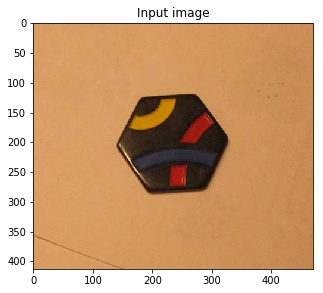

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Number of chip is 10


In [103]:
img = read_img('single', 'Single_1.bmp')
io.imshow(img)
plt.title('Input image')
plt.show()
solve_problem(img, problem_what_chip)